<a href="https://colab.research.google.com/github/mat-roa/Fase_02-Pos_Tech_FIAP/blob/main/Tech_Challenge_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install holidays

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from holidays import country_holidays
import holidays

In [ ]:
# Importando os dados do IBOVESPA, mudando o tipo da coluna Data para datetime, renomeando as colunas para utilizar elas no prophet
# dropando colunas desnecessárias e visualizando o DF

df = pd.read_csv('/content/drive/MyDrive/FIAP/Fase 02/Tech Challenge/Ibovespa_4anos.csv')
df['Data'] = pd.to_datetime(df['Data'],format='%d.%m.%Y')
df = df.rename(columns={'Data':'ds','Último':'y'})
df.drop(['Abertura','Máxima','Mínima','Vol.','Var%'], inplace=True, axis=1)
df

,ds,y
0,2024-01-25,128.169
1,2024-01-24,127.816
2,2024-01-23,128.263
3,2024-01-22,126.602
4,2024-01-19,127.636
...,...,...
991,2020-01-30,115.528
992,2020-01-29,115.385
993,2020-01-28,116.479
994,2020-01-27,114.482


Text(0.5, 0, '')

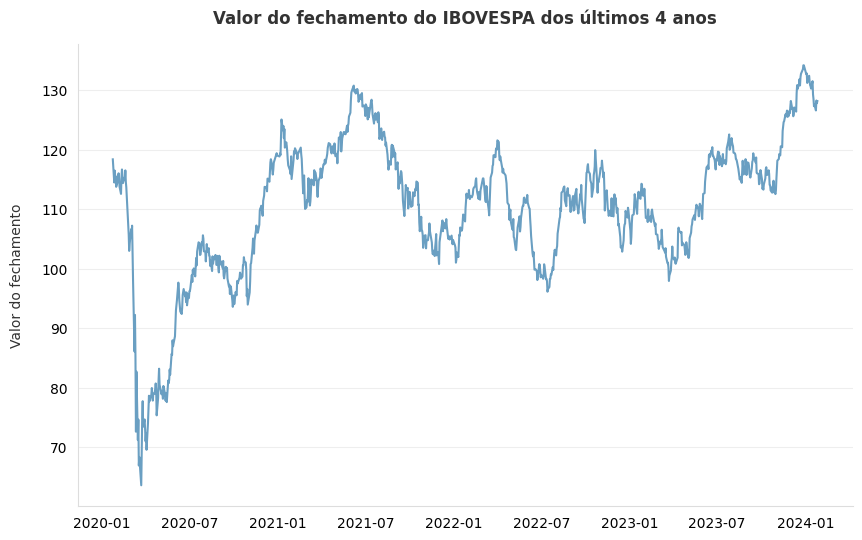

In [ ]:
# Visualizando os dados
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=df,x=df.ds,y=df.y, color='#6A9FC2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')

plt.title('Valor do fechamento do IBOVESPA dos últimos 4 anos', pad=15, color='#333333', weight='bold')
plt.ylabel('Valor do fechamento', labelpad=12.5, color='#333333')
plt.xlabel(xlabel=None)

In [ ]:
# Criando o df de feriados no brasil para melhorar o treinamento do modelo
nsw_holidays = make_holidays_df(
    year_list=[2020 + i for i in range(6)], country='BR', province='SP')
nsw_holidays.tail(10)

,ds,holiday
50,2025-01-01,Confraternização Universal
51,2025-04-18,Sexta-feira Santa
52,2025-04-21,Tiradentes
53,2025-05-01,Dia do Trabalhador
54,2025-09-07,Independência do Brasil
55,2025-10-12,Nossa Senhora Aparecida
56,2025-11-02,Finados
57,2025-11-15,Proclamação da República
58,2025-12-25,Natal
59,2025-07-09,Revolução Constitucionalista


In [ ]:
# Criando uma instância do Prophet, adicionando o df de feriados e passando o df do ibovespa pelo metodo fit do Prophet
m = Prophet(holidays=nsw_holidays)
m.add_country_holidays(country_name='BR')
m.fit(df)

In [ ]:
# Criando um df com as datas dos proximos 6 meses com a frequência de dias úteis
future = m.make_future_dataframe(periods=100, freq='B')
future.tail(10)

,ds
1086,2024-05-31
1087,2024-06-03
1088,2024-06-04
1089,2024-06-05
1090,2024-06-06
1091,2024-06-07
1092,2024-06-10
1093,2024-06-11
1094,2024-06-12
1095,2024-06-13


In [ ]:
# Fazendo a predição do fechamento dos proximos 6 meses com o intervalo de confiança
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1091,2024-06-07,136.144205,126.372980,145.369690
1092,2024-06-10,136.373343,126.446008,146.598870
1093,2024-06-11,136.593835,126.670036,146.358001
1094,2024-06-12,136.635498,126.227049,146.493383
1095,2024-06-13,136.673830,126.200286,146.920498


<Figure size 1200x600 with 0 Axes>

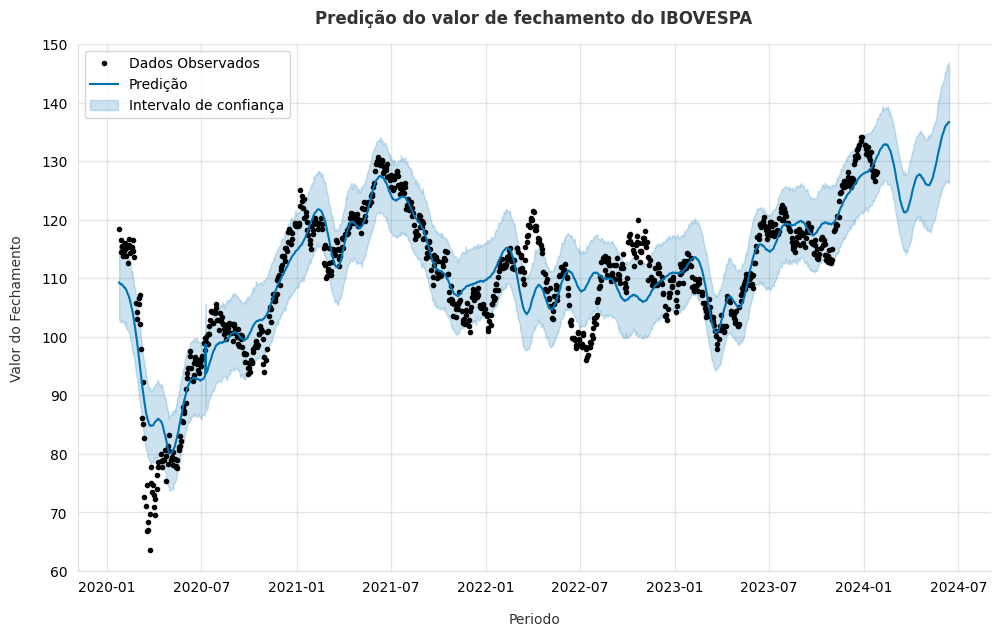

In [ ]:
# Plotando os dados observados, a predição dos proximos 6 meses junto com o intervalo de confiança
plt.figure(figsize=(12,6))
m.plot(forecast)
ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)

plt.title("Predição do valor de fechamento do IBOVESPA", pad=15, color='#333333', weight='bold')
plt.legend(['Dados Observados', 'Predição', 'Intervalo de confiança'], loc='upper left')
plt.ylabel("Valor do Fechamento", labelpad=12.5, color='#333333')
plt.xlabel("Periodo", labelpad=12.5, color='#333333')
plt.ylim(60,150)
plt.show()

In [ ]:
#Vendo o desempenho do modelo
def wmape(y_true,y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

wmape1 = wmape(df.y,forecast.yhat)
print(f"WMAPE: {wmape1:.2}")

WMAPE: 0.13


<h2>acuracidade > 70%</h2>